In [1]:
import sys

#######
DATA_IDX = 1
DATA_FNAME = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(DATA_IDX)
print(DATA_FNAME)

N_RUNS = 10
import warnings
warnings.filterwarnings("ignore")
#####


# In[2]:


import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))


# In[3]:


from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


# In[4]:


print("Map properties")

# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3


from tqdm import trange,tqdm 
import pickle

from itertools import product

poss = list(product([True, False], range(N_RUNS)))


oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)




ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)

L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi
fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S4/SO specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_1.pkl
Map properties
../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [2]:
tot = np.array(list(map(ftot, L)))
currL = np.copy(L)

In [3]:
# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [4]:
cmbCtotal = np.array(list(map(cmb.fCtotal, L)))

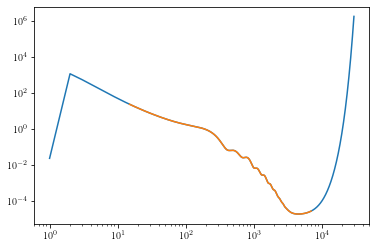

In [5]:
plt.plot(currL, tot)
plt.plot(L, cmbCtotal)

plt.xscale('log')
plt.yscale('log')

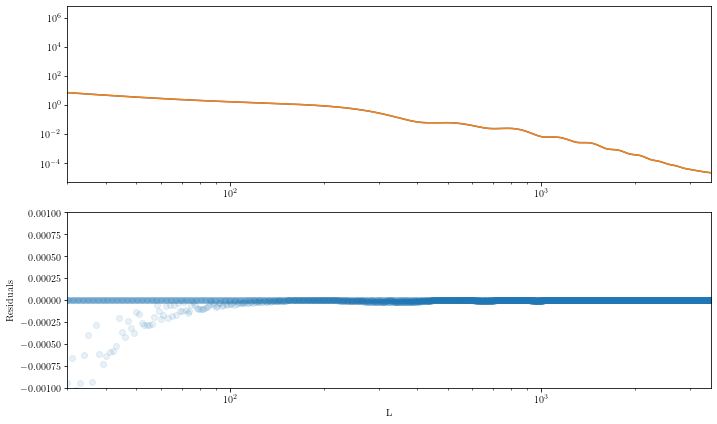

In [12]:
from scipy.interpolate import interp1d

# Interpolation functions for the two curves
interp_tot = interp1d(currL, tot, kind='linear', bounds_error=False, fill_value=0.)
interp_cmbCtotal = interp1d(L, cmbCtotal, kind='linear', bounds_error=False, fill_value=0.)

# Common x-values (you could also choose new common x-values, such as log-spaced values)
common_L = np.sort(np.unique(np.concatenate([currL, L])))

# Evaluate both curves at the common x-values
interp_tot_y = interp_tot(common_L)
interp_cmbCtotal_y = interp_cmbCtotal(common_L)

# Compute the residuals
residuals = interp_tot_y - interp_cmbCtotal_y

# Plot the original curves
plt.figure(figsize=[10,6])
plt.subplot(2,1,1)
plt.plot(currL, tot)
plt.plot(L, cmbCtotal)
plt.xscale('log')
plt.yscale('log')
plt.xlim(lMin, lMax)

# Plot the residuals
plt.subplot(2,1,2)
plt.scatter(common_L, residuals, alpha=0.1)
plt.xscale('log')
plt.xlabel('L')
plt.ylim([-1e-3,1e-3])
plt.xlim(lMin, lMax)
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()